# Individual Project Antoine QUINIOU

## Librairies

In [1]:
import os, sys
import time
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import math
from tqdm import tqdm
import text_flappy_bird_gym
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

## Environnement

We set the TextFlappyBird-v0 environnement with a given configuration : height=15, width=20, pipe gap=4.

In [2]:
env = gym.make('TextFlappyBird-v0', height = 15, width = 20, pipe_gap = 4)

## Monte-Carlo Agent

First, I implement a Model-Free First-Visit Monte-Carlo Agent with a Q-table. The Agent :
- learns directly from experience without environment dynamics and from complete episodes
- only considers the first occurrence of each state-action pair in an episode
- employs an epsilon-greedy strategy for balancing exploration and exploitation
- uses a Q-table which stores exact value estimates for each discrete (x,y) state and action pair

In [4]:
class MonteCarloAgent:
    def __init__(self, env, gamma=0.99, epsilon=0.1, epsilon_decay=0.999, min_epsilon=0.01):
        self.env = env
        self.gamma = gamma # discount factor
        self.epsilon = epsilon # exploration-explotation tradeoff
        self.epsilon_decay = epsilon_decay # decay exploration rate -> improve stability
        self.min_epsilon = min_epsilon
        
        # Q-table (14 possible x positions × 23 possible y positions × 2 actions)
        self.Q = np.zeros((14, 23, 2))
        
        self.returns_sum = defaultdict(float)
        self.returns_count = defaultdict(float)
    
    def get_action(self, state):
        x, y = state
        y_idx = y + 11
        if np.random.random() < self.epsilon:
            return self.env.action_space.sample()  # exploration
        else:
            return np.argmax(self.Q[x, y_idx]) # explotation
    
    def update_epsilon(self):
        self.epsilon = max(self.min_epsilon, self.epsilon * self.epsilon_decay)
    
    def train(self, num_episodes=1000):
        episode_rewards = []
        
        for episode in tqdm(range(num_episodes)):
            # generate an episode
            episode_data = []
            state, info = self.env.reset()
            done = False
            total_reward = 0
            
            while not done:
                action = self.get_action(state)
                next_state, reward, done, _, info = self.env.step(action)
                episode_data.append((state, action, reward))
                state = next_state
                total_reward += reward
            
            episode_rewards.append(total_reward)
            
            # process episode with first-visit Monte-Carlo
            G = 0
            visited_states = set()
            
            for t in reversed(range(len(episode_data))):
                state, action, reward = episode_data[t]
                x, y = state
                y_idx = y + 11
                state_action = (x, y_idx, action)
                
                G = self.gamma * G + reward
                
                # only update the first time a state-action pair is visited
                if state_action not in visited_states:
                    visited_states.add(state_action)
                    self.returns_sum[state_action] += G
                    self.returns_count[state_action] += 1
                    self.Q[x, y_idx, action] = self.returns_sum[state_action] / self.returns_count[state_action]
            
            self.update_epsilon()
        
        return episode_rewards

I train the Monte-Carlo Agent with 30000 episodes and a discount factor equal to 0.99. I train it with multiple values of epsilon to asses the exploration/explotation tradeoff.

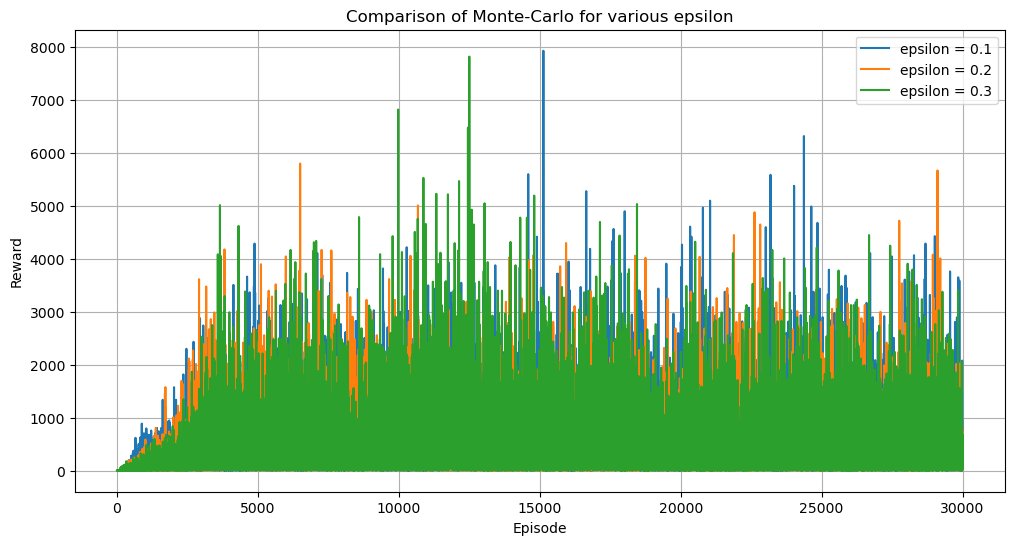

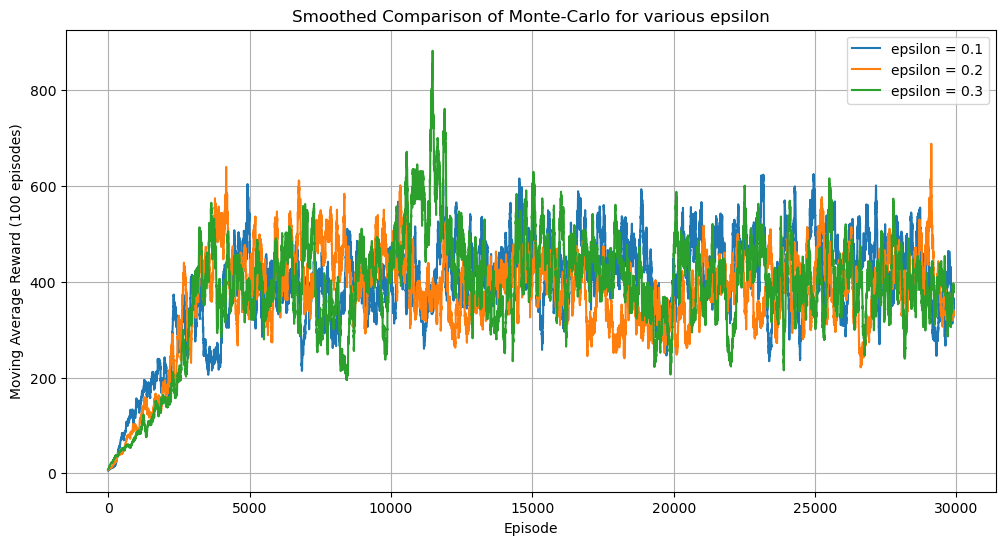

In [16]:
mc_agent_eps_0_1 = MonteCarloAgent(env, epsilon = 0.1)
mc_rewards_0_1 = mc_agent_eps_0_1.train(num_episodes=30000)
mc_agent_eps_0_2 = MonteCarloAgent(env, epsilon = 0.2)
mc_rewards_0_2 = mc_agent_eps_0_2.train(num_episodes=30000)
mc_agent_eps_0_3 = MonteCarloAgent(env, epsilon = 0.3)
mc_rewards_0_3 = mc_agent_eps_0_3.train(num_episodes=30000)

plt.figure(figsize=(12, 6))
plt.plot(mc_rewards_0_1, label='epsilon = 0.1')
plt.plot(mc_rewards_0_2, label='epsilon = 0.2')
plt.plot(mc_rewards_0_3, label='epsilon = 0.3')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Comparison of Monte-Carlo for various epsilon')
plt.legend()
plt.grid()
plt.show()

window_size = 100
mc_0_1_moving_avg = np.convolve(mc_rewards_0_1, np.ones(window_size)/window_size, mode='valid')
mc_0_2_moving_avg = np.convolve(mc_rewards_0_2, np.ones(window_size)/window_size, mode='valid')
mc_0_3_moving_avg = np.convolve(mc_rewards_0_3, np.ones(window_size)/window_size, mode='valid')

plt.figure(figsize=(12, 6))
plt.plot(mc_0_1_moving_avg, label='epsilon = 0.1')
plt.plot(mc_0_2_moving_avg, label='epsilon = 0.2')
plt.plot(mc_0_3_moving_avg, label='epsilon = 0.3')
plt.xlabel('Episode')
plt.ylabel('Moving Average Reward (100 episodes)')
plt.title('Smoothed Comparison of Monte-Carlo for various epsilon')
plt.legend()
plt.grid()
plt.show()

## Sarsa(λ)

Then, I implement a Sarsa(λ) Agent with Linear Function Approximation. The Sarsa(λ) Agent :
- learns action-values (Q) using temporal difference (TD) updates
- uses eligibility traces (λ) to efficiently propagate credit back through visited states
- employs tile coding for function approximation to handle continuous state spaces
- balances exploration/exploitation via ε-greedy policy. 
- improve its performance over time by decaying the exploration rate

In [17]:
class SarsaLambdaAgent:
    def __init__(self, env, gamma=0.99, alpha=0.01, lambda_=0.9, epsilon=0.1, epsilon_decay=0.999, min_epsilon=0.01, x_tilings=5, y_tilings=5, n_features=20):
        self.env = env
        self.gamma = gamma # discount factor
        self.alpha = alpha # learning rate
        self.lambda_ = lambda_ # eligibility trace
        self.epsilon = epsilon # exploration/explotation tradeoff
        self.epsilon_decay = epsilon_decay # decay exploration rate -> improve stability
        self.min_epsilon = min_epsilon
        
        # tile coding for feature representation
        self.x_tilings = x_tilings  # tilings along x-axis
        self.y_tilings = y_tilings  # tilings along y-axis
        self.n_features = n_features  # features per tiling
        
        self.weights = np.zeros((env.action_space.n, self.x_tilings * self.y_tilings * self.n_features))
        
        # discretization for tile coding
        self.x_bins = np.linspace(0, 13, self.n_features)
        self.y_bins = np.linspace(-11, 10, self.n_features)
    
    def get_features(self, state):
        # get_features creates multiple overlapping tilings (grids) of the state space which enables smooth value function approximation
        x, y = state
        features = np.zeros((self.x_tilings, self.y_tilings, self.n_features))
        
        for i in range(self.x_tilings):
            x_offset = i * (self.x_bins[1] - self.x_bins[0]) / self.x_tilings
            x_idx = np.digitize(x + x_offset, self.x_bins) - 1
            x_idx = np.clip(x_idx, 0, self.n_features-1)
            
            for j in range(self.y_tilings):
                y_offset = j * (self.y_bins[1] - self.y_bins[0]) / self.y_tilings
                y_idx = np.digitize(y + y_offset, self.y_bins) - 1
                y_idx = np.clip(y_idx, 0, self.n_features-1)
                
                features[i, j, x_idx] = 1
                features[i, j, y_idx] = 1
        
        return features.flatten()
    
    def Q_value(self, state, action):
        features = self.get_features(state)
        return np.dot(self.weights[action], features)
    
    def get_action(self, state):
        if np.random.random() < self.epsilon:
            return self.env.action_space.sample() # exploration
        else:
            q_values = [self.Q_value(state, a) for a in range(self.env.action_space.n)]
            return np.argmax(q_values) # explotation
    
    def update_epsilon(self):
        # epsilon decay
        self.epsilon = max(self.min_epsilon, self.epsilon * self.epsilon_decay)
    
    def train(self, num_episodes=1000):
        ## train method returns a list of total rewards for each episode to monitor the agent's performance over time.
        episode_rewards = []
        
        for episode in tqdm(range(num_episodes)):
            # generate episode
            
            # initialize eligibility traces
            z = np.zeros_like(self.weights)
            
            state, info = env.reset()
            action = self.get_action(state)
            done = False
            total_reward = 0
            
            while not done:
                next_state, reward, done, _, info = env.step(action)
                next_action = self.get_action(next_state)
                total_reward += reward
                
                # Temporal Difference error
                current_q = self.Q_value(state, action)
                next_q = self.Q_value(next_state, next_action) if not done else 0
                td_error = reward + self.gamma * next_q - current_q
                
                # update eligibility traces
                features = self.get_features(state)
                z[action] += features
                
                # update weights
                self.weights += self.alpha * td_error * z
                z *= self.gamma * self.lambda_
                
                state = next_state
                action = next_action
            
            episode_rewards.append(total_reward)
            self.update_epsilon()
        
        return episode_rewards

I train the Sarsa(λ) Agent with (only) 2000 episodes (as the code for this agent is much slower) and a discount factor equal to 0.99. I train it with multiple values of λ to asses the importance of eligibility traces.

  0%|          | 4/2000 [00:00<01:43, 19.30it/s]

100%|██████████| 2000/2000 [12:07<00:00,  2.75it/s]


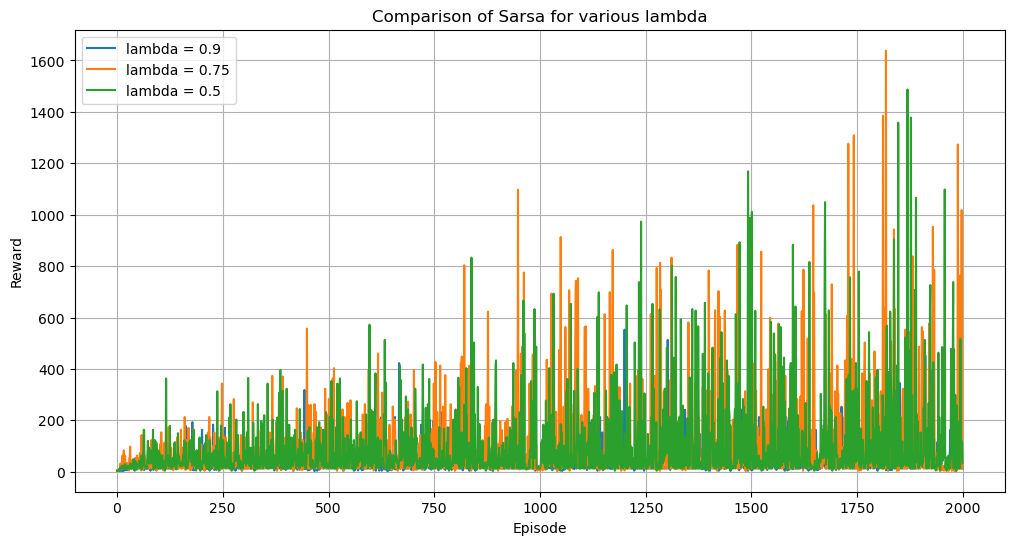

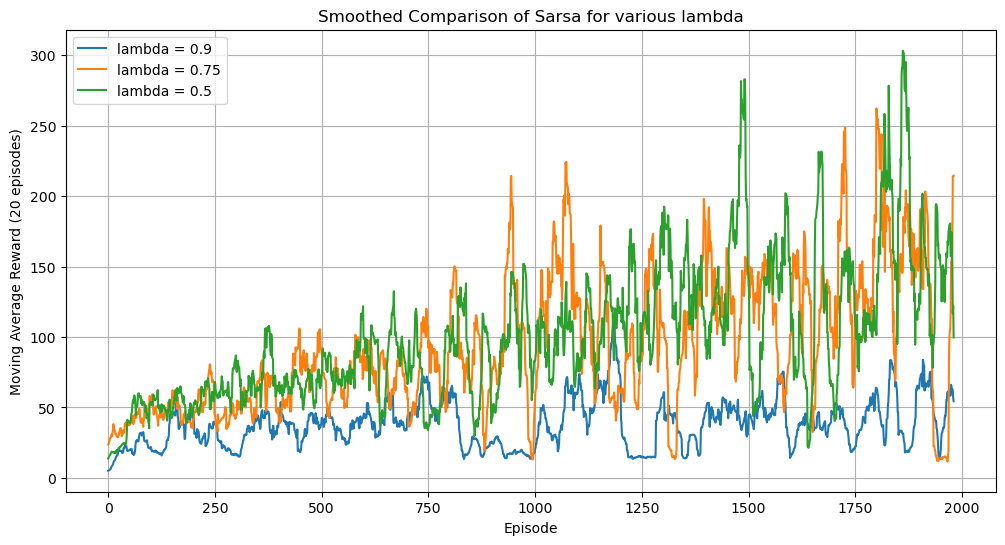

In [18]:
sarsa_agent_lbd_0_9 = SarsaLambdaAgent(env, lambda_ = 0.9)
sarsa_agent_lbd_0_75 = SarsaLambdaAgent(env, lambda_ = 0.75)
sarsa_agent_lbd_0_5 = SarsaLambdaAgent(env, lambda_ = 0.5)
sarsa_rewards_0_9 = sarsa_agent_lbd_0_9.train(num_episodes=2000)
sarsa_rewards_0_75 = sarsa_agent_lbd_0_75.train(num_episodes=2000)
sarsa_rewards_0_5 = sarsa_agent_lbd_0_5.train(num_episodes=2000)

plt.figure(figsize=(12, 6))
plt.plot(sarsa_rewards_0_9, label='lambda = 0.9')
plt.plot(sarsa_rewards_0_75, label='lambda = 0.75')
plt.plot(sarsa_rewards_0_5, label='lambda = 0.5')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Comparison of Sarsa for various lambda')
plt.legend()
plt.grid()
plt.show()

window_size = 20
sarsa_0_9_moving_avg = np.convolve(sarsa_rewards_0_9, np.ones(window_size)/window_size, mode='valid')
sarsa_0_75_moving_avg = np.convolve(sarsa_rewards_0_75, np.ones(window_size)/window_size, mode='valid')
sarsa_0_5_moving_avg = np.convolve(sarsa_rewards_0_5, np.ones(window_size)/window_size, mode='valid')

plt.figure(figsize=(12, 6))
plt.plot(sarsa_0_9_moving_avg, label='lambda = 0.9')
plt.plot(sarsa_0_75_moving_avg, label='lambda = 0.75')
plt.plot(sarsa_0_5_moving_avg, label='lambda = 0.5')
plt.xlabel('Episode')
plt.ylabel('Moving Average Reward (20 episodes)')
plt.title('Smoothed Comparison of Sarsa for various lambda')
plt.legend()
plt.grid()
plt.show()

## State-Value function plot

Finally, I plot the state-value functions for both agents (each chosen with the same best parameter set : epsilon = 0.1 for the Monte-Carlo Agent et lbd = 0.5 for the Sarsa Agent).

In [20]:
def plot_state_value_function(agent, agent_type, env):

    # grid of states
    x_values = np.arange(14)  # x ∈ [0,13]
    y_values = np.arange(-11, 11)  # y ∈ [-11,11]
    X, Y = np.meshgrid(x_values, y_values)
    V = np.zeros_like(X, dtype=float)
    
    # state values
    for i, x in enumerate(x_values):
        for j, y in enumerate(y_values):
            state = (x, y)
            
            if agent_type == 'MC':
                y_idx = y + 11  # convert y to [0,22] index
                V[j,i] = np.max(agent.Q[x, y_idx])  # Monte-Carlo : max Q-value = state value
            elif agent_type == 'SARSA':
                # Sarsa(λ) : calculate max Q-value using the approximated function
                q_values = [agent.Q_value(state, a) for a in range(env.action_space.n)]
                V[j,i] = np.max(q_values)
    
    # 3D surface plot
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')
    surf = ax.plot_surface(X, Y, V, cmap='viridis', edgecolor='none')
    ax.set_xlabel('Horizontal Distance (x)')
    ax.set_ylabel('Vertical Distance (y)')
    ax.set_zlabel('State Value (V)')
    ax.set_title(f'State-Value Function')
    fig.colorbar(surf, shrink=0.5, aspect=5)
    
    plt.tight_layout()
    plt.show()

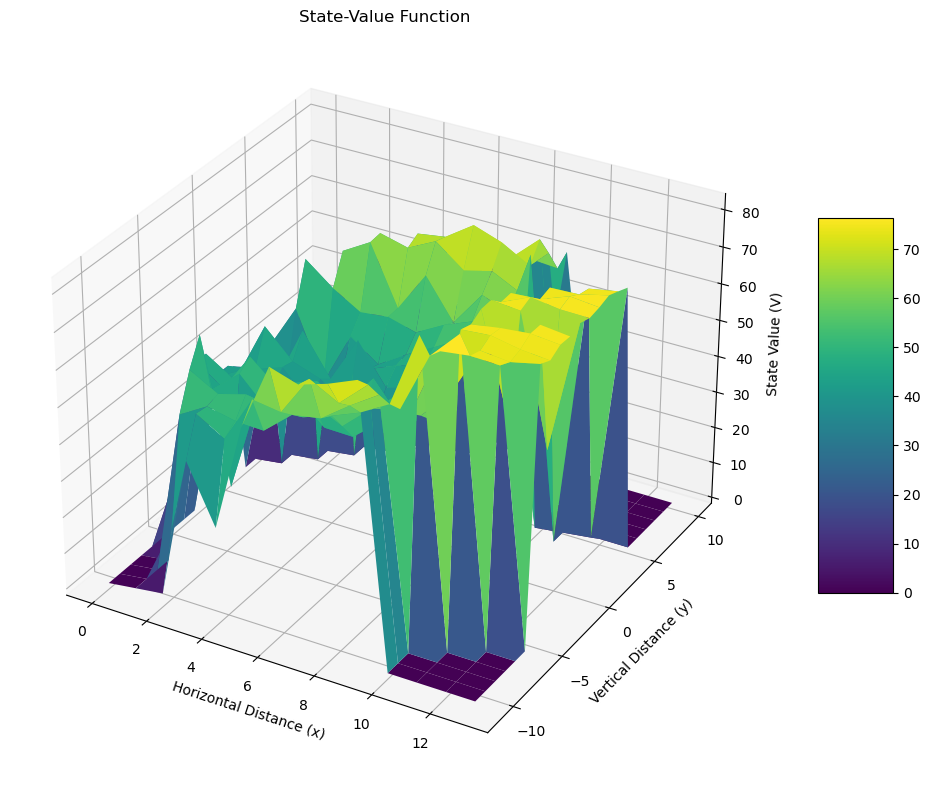

In [21]:
plot_state_value_function(mc_agent_eps_0_1, 'MC', env)

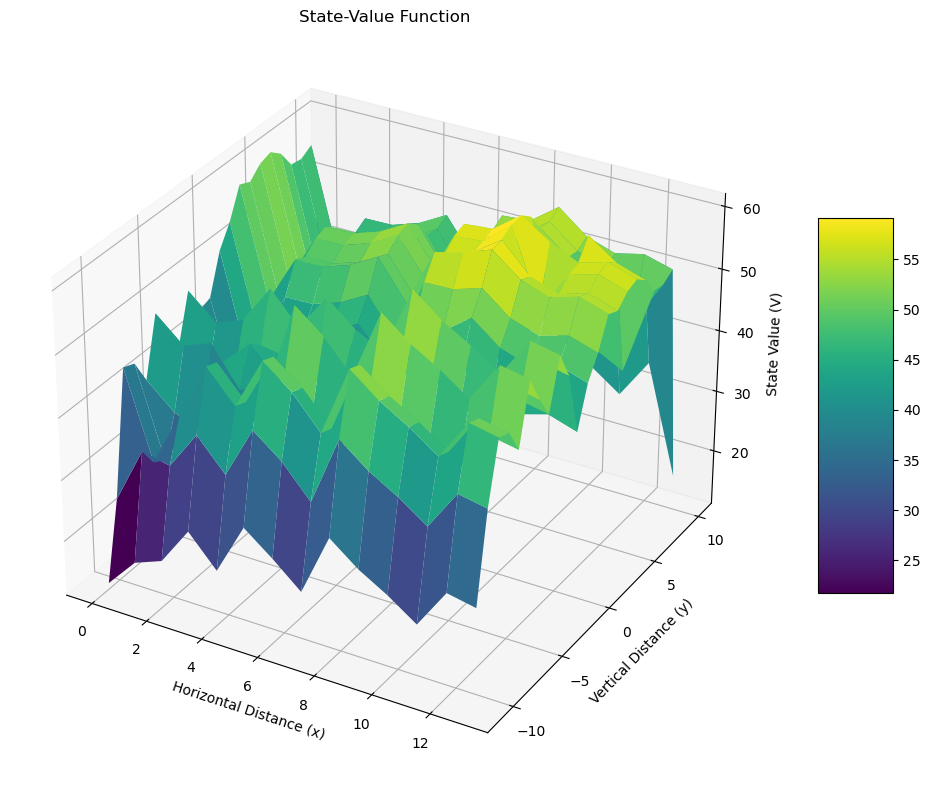

In [22]:
plot_state_value_function(sarsa_agent_lbd_0_5, 'SARSA', env)

## Performance of Agents

We test the performance of both agents in the game.

In [9]:
score = []
for game in range(100):

    obs, info = env.reset()
    # iterate
    while True:

        # Select next action
        action = mc_agent_eps_0_1.get_action(obs) # for an agent, action = agent.policy(observation)

        # Appy action and return new observation of the environment
        obs, reward, done, _, info = env.step(action)

        # If player is dead break
        if done:
            break
    
    score.append(info['score'])
    env.close()

print('score moyen', round(np.mean(np.array(score))))
print('score max', round(np.max(np.array(score))))


score moyen 44
score max 217


In [23]:
score = []
for game in range(100):

    obs, info = env.reset()
    # iterate
    while True:

        # Select next action
        action = sarsa_agent_lbd_0_5.get_action(obs) # for an agent, action = agent.policy(observation)

        # Appy action and return new observation of the environment
        obs, reward, done, _, info = env.step(action)

        # If player is dead break
        if done:
            break
    
    score.append(info['score'])
    env.close()

print('score moyen', round(np.mean(np.array(score))))
print('score max', round(np.max(np.array(score))))


score moyen 44
score max 287


## Generalization Across Level Configurations

In [10]:
env_ = gym.make('TextFlappyBird-v0', height = 10, width = 15, pipe_gap = 3)

In [11]:
score = []
for game in range(100):

    obs, info = env_.reset()
    # iterate
    while True:

        # Select next action
        action = mc_agent_eps_0_1.get_action(obs) # for an agent, action = agent.policy(observation)

        # Appy action and return new observation of the environment
        obs, reward, done, _, info = env_.step(action)

        # If player is dead break
        if done:
            break
    
    score.append(info['score'])
    env_.close()

print('score moyen', round(np.mean(np.array(score))))
print('score max', round(np.max(np.array(score))))


score moyen 2
score max 14


In [24]:
score = []
for game in range(100):

    obs, info = env_.reset()
    # iterate
    while True:

        # Select next action
        action = sarsa_agent_lbd_0_5.get_action(obs) # for an agent, action = agent.policy(observation)

        # Appy action and return new observation of the environment
        obs, reward, done, _, info = env_.step(action)

        # If player is dead break
        if done:
            break
    
    score.append(info['score'])
    env_.close()

print('score moyen', round(np.mean(np.array(score))))
print('score max', round(np.max(np.array(score))))


score moyen 11
score max 53
